In [1]:
import os
import shutil

# Standard library for data sciene
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split

# necessary libraries
import keras
from sklearn.base import BaseEstimator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from keras.models import Model, Sequential
from keras import layers

import tensorflow as tf

2024-04-16 23:16:36.631827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 23:16:36.631952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 23:16:36.903165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Read the CSV file into a DataFrame
data = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")

data.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


### Load Data

In [3]:
# Concatenate filename with root directory
data['path'] = '/kaggle/input/butterfly-image-classification/train/' + data['filename']

data.head()

,filename,label,path
0,Image_1.jpg,SOUTHERN DOGFACE,/kaggle/input/butterfly-image-classification/t...
1,Image_2.jpg,ADONIS,/kaggle/input/butterfly-image-classification/t...
2,Image_3.jpg,BROWN SIPROETA,/kaggle/input/butterfly-image-classification/t...
3,Image_4.jpg,MONARCH,/kaggle/input/butterfly-image-classification/t...
4,Image_5.jpg,GREEN CELLED CATTLEHEART,/kaggle/input/butterfly-image-classification/t...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
 2   path      6499 non-null   object
dtypes: object(3)
memory usage: 152.4+ KB


In [5]:
butterfly_classes = data['label'].unique()
butterfly_class_num = data['label'].nunique()

print('Classes:')
print(butterfly_classes)

print('-'*80)
print('Number of Classes:')
print(butterfly_class_num)

Classes:
['SOUTHERN DOGFACE' 'ADONIS' 'BROWN SIPROETA' 'MONARCH'
 'GREEN CELLED CATTLEHEART' 'CAIRNS BIRDWING' 'EASTERN DAPPLE WHITE'
 'RED POSTMAN' 'MANGROVE SKIPPER' 'BLACK HAIRSTREAK' 'CABBAGE WHITE'
 'RED ADMIRAL' 'PAINTED LADY' 'PAPER KITE' 'SOOTYWING' 'PINE WHITE'
 'PEACOCK' 'CHECQUERED SKIPPER' 'JULIA' 'COMMON WOOD-NYMPH' 'BLUE MORPHO'
 'CLOUDED SULPHUR' 'STRAITED QUEEN' 'ORANGE OAKLEAF' 'PURPLISH COPPER'
 'ATALA' 'IPHICLUS SISTER' 'DANAID EGGFLY' 'LARGE MARBLE'
 'PIPEVINE SWALLOW' 'BLUE SPOTTED CROW' 'RED CRACKER' 'QUESTION MARK'
 'CRIMSON PATCH' 'BANDED PEACOCK' 'SCARCE SWALLOW' 'COPPER TAIL'
 'GREAT JAY' 'INDRA SWALLOW' 'VICEROY' 'MALACHITE' 'APPOLLO'
 'TWO BARRED FLASHER' 'MOURNING CLOAK' 'TROPICAL LEAFWING' 'POPINJAY'
 'ORANGE TIP' 'GOLD BANDED' 'BECKERS WHITE' 'RED SPOTTED PURPLE'
 'MILBERTS TORTOISESHELL' 'SILVER SPOT SKIPPER' 'AMERICAN SNOOT' 'AN 88'
 'ULYSES' 'COMMON BANDED AWL' 'CRECENT' 'METALMARK' 'SLEEPY ORANGE'
 'PURPLE HAIRSTREAK' 'ELBOWED PIERROT' 'GREAT EGGFLY' 

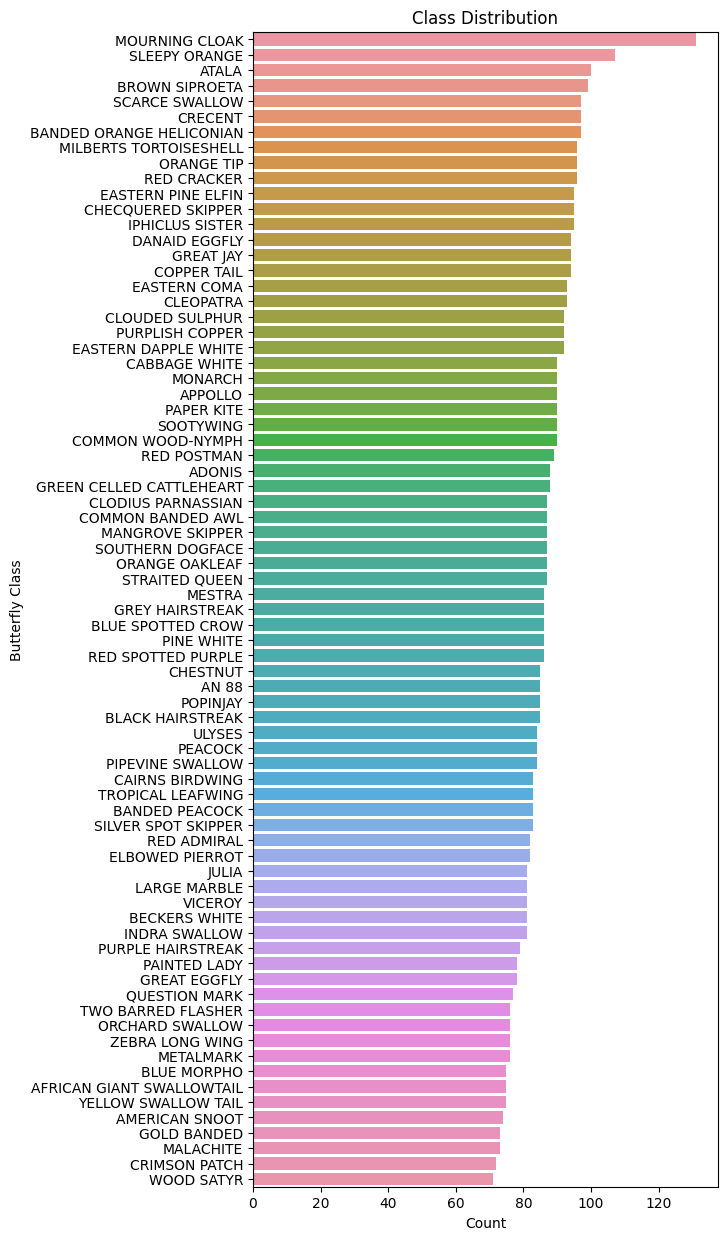

In [6]:
plt.figure(figsize=(6, 15))
sns.countplot(y='label', data=data, order=data['label'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Butterfly Class')
plt.title('Class Distribution')
plt.show()

In [7]:
# Split data into training and validation sets
train_data, validation_data = train_test_split(data, test_size=0.3, random_state=42)

### Data Preprocessing

In [9]:
# Split data into training and validation sets
train_data, validation_data = train_test_split(data, test_size=0.3, random_state=42)

In [10]:
train_data.head()

,filename,label,path
3758,Image_3759.jpg,BLUE MORPHO,/kaggle/input/butterfly-image-classification/t...
5879,Image_5880.jpg,ULYSES,/kaggle/input/butterfly-image-classification/t...
4907,Image_4908.jpg,BLUE MORPHO,/kaggle/input/butterfly-image-classification/t...
5198,Image_5199.jpg,WOOD SATYR,/kaggle/input/butterfly-image-classification/t...
4733,Image_4734.jpg,EASTERN DAPPLE WHITE,/kaggle/input/butterfly-image-classification/t...


In [11]:
def prep_data(train_data, validation_data, batch_size=16):
    # Create ImageDataGenerator for training set
    train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    train_set = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='path',
        y_col='label',
        target_size=(180, 180),
        batch_size=batch_size,
        class_mode='sparse')

    # Create ImageDataGenerator for validation set
    validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    validation_set = validation_datagen.flow_from_dataframe(
        dataframe=validation_data,
        x_col='path',
        y_col='label',
        target_size=(180, 180),
        batch_size=batch_size,
        class_mode='sparse')

    return train_set, validation_set

In [12]:
# visulization function for Models
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

### Visualizing Data

In [13]:
train_set, validation_set = prep_data(train_data, validation_data)

# Accessing the data
images, labels = next(train_set)

# Retrieving class names
class_names = train_set.class_indices
class_names = {v: k for k, v in class_names.items()}

Found 4549 validated image filenames belonging to 75 classes.
Found 1950 validated image filenames belonging to 75 classes.


In [14]:
train_set

### Image Classification using EfficientNet v2 Model from Keras

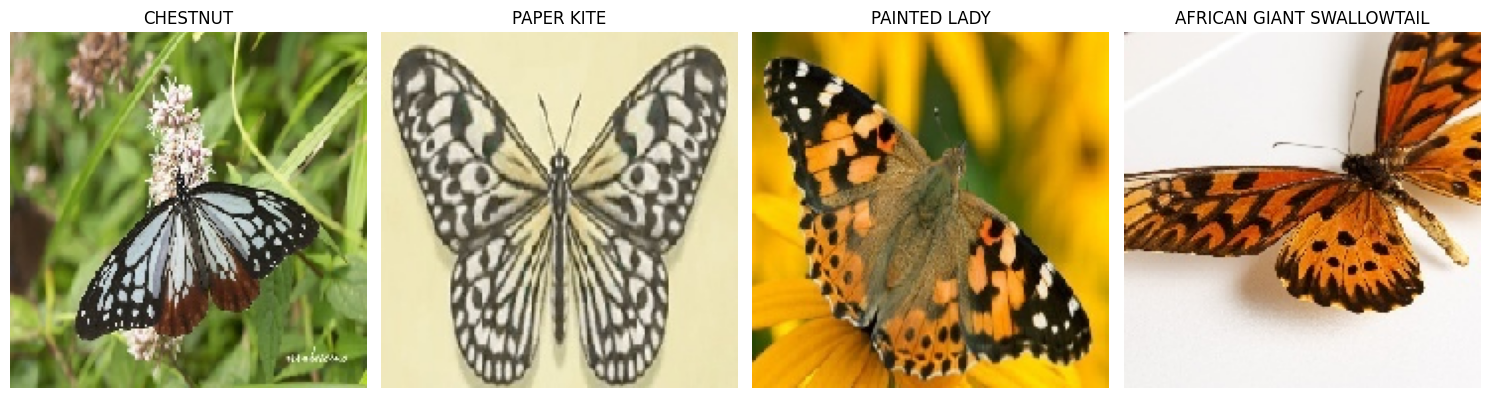

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    axes[i].imshow(images[i]) 
    label_index = int(labels[i])
    class_name = class_names[label_index]
    axes[i].set_title(f"{class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# importing pretrained models 
from tensorflow.keras.applications import InceptionV3

In [17]:
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
# Freeze the layers except the last few layers
for layer in base_model.layers[:-15]:
    layer.trainable = False

In [19]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(butterfly_class_num, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005), 
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 394,880 (1.51 MB)

 Non-trainable params: 21,407,904 (81.66 MB)

In [22]:
modelv1 = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,
    )

Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 1.0000 - loss: 3.9565e-04 - val_accuracy: 0.8400 - val_loss: 0.7231
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 1.0000 - loss: 7.9837e-04 - val_accuracy: 0.8436 - val_loss: 0.7280
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 1.0000 - loss: 3.2606e-04 - val_accuracy: 0.8467 - val_loss: 0.7357
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 1.0000 - loss: 3.5983e-04 - val_accuracy: 0.8477 - val_loss: 0.7259
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 1.0000 - loss: 2.3306e-04 - val_accuracy: 0.8482 - val_loss: 0.7281
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 1.0000 - loss: 2.2530e-04 - val_accuracy: 0.8487 - val_loss: 0.7232
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 1.0000 - loss: 2.1068e-04 - val_accuracy: 0.8477 - val_loss: 0.7366
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accura

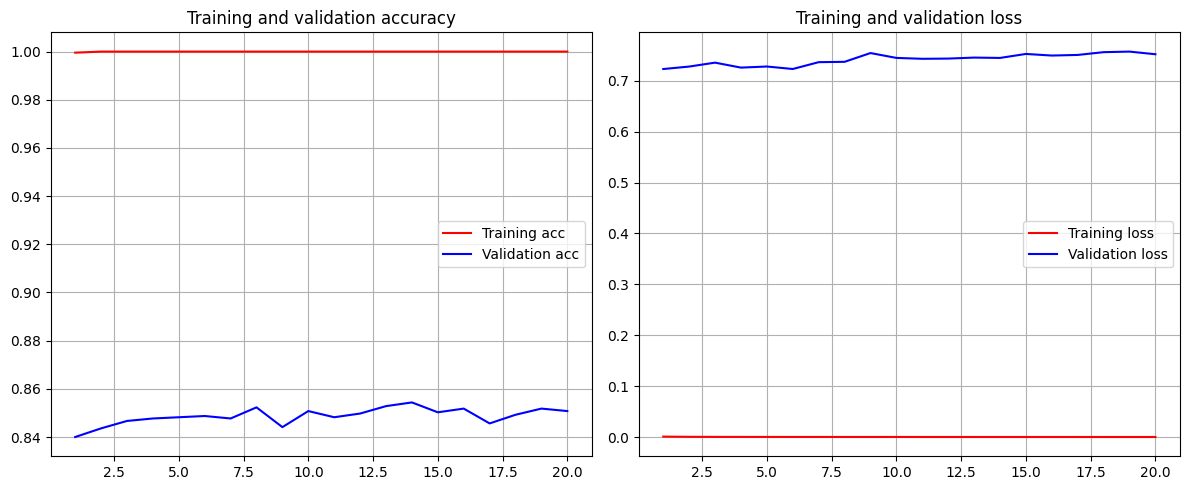

In [23]:
visualize(modelv1)

In [24]:
model2 = Sequential()
model2.add(base_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.25))
model2.add(layers.Dense(90, activation='softmax'))

model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 4, 4, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 394,880 (1.51 MB)

 Non-trainable params: 21,407,904 (81.66 MB)

In [25]:
modelv2 = model2.fit(
    train_set,
    epochs=30,
    validation_data=validation_set,
)

Epoch 1/30
  5/285 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.0000e+00 - loss: 4.8020 

W0000 00:00:1713306980.870247     250 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 39/285 ━━━━━━━━━━━━━━━━━━━━ 59s 243ms/step - accuracy: 0.0094 - loss: 4.5997 

W0000 00:00:1713306989.935519     248 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.0876 - loss: 4.1180

W0000 00:00:1713307005.889780     249 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


285/285 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - accuracy: 0.0880 - loss: 4.1161 - val_accuracy: 0.5067 - val_loss: 2.2446
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.5101 - loss: 2.0304 - val_accuracy: 0.7077 - val_loss: 1.2998
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.7142 - loss: 1.1394 - val_accuracy: 0.7672 - val_loss: 0.9380
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8337 - loss: 0.6532 - val_accuracy: 0.7949 - val_loss: 0.7961
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.8971 - loss: 0.4088 - val_accuracy: 0.8077 - val_loss: 0.7145
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9285 - loss: 0.2830 - val_accuracy: 0.8144 - val_loss: 0.7134
Epoch 7/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9615 - loss: 0.1853 - val_accuracy: 0.8174 - val_loss: 0.6854
Epoch 8/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9647 - loss: 0.1409 - val_accura

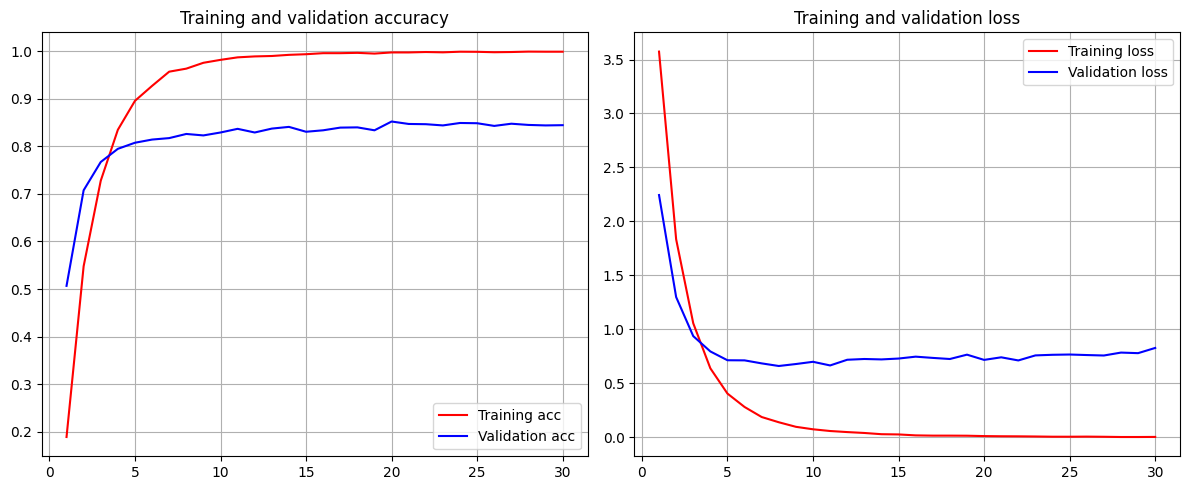

In [32]:
visualize(modelv2)

In [36]:
y_pred = modelv2.predict(validation_set)

AttributeError: 'History' object has no attribute 'predict'